In [238]:
%matplotlib inline
import matplotlib.pyplot as plt
from model import *

In [255]:
#paramaters for SIMULATION

vaultToken = 'USDC'
secondaryToken = 'FTM'

#LP Size 
volume1 =  2000000 #amount of vaultToken in LP
volume2 =  volume1*5 #amount of secondary token in LP

# VAULT INFO
vaultTVL = 100 # amount of vault Token in LP 
lendAllocation = .65
#debt thresholds for rebalancing
debtLow = .97
debtHigh = 1.03
collatLow = .5
collatTarget = .55
collatHigh = .6
harvestTreshold = 1
rebalanceAdj = .996 #when rebalancing losses from swapping 

# APY's
lendRate = .05
borrowRate = .03
farmRate = .35

#SIM INFO
stepsPerYear = 365*24*30 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'farm' : farmRate}
adjRates = {'lend' : ((1 + lendRate)**(1/stepsPerYear) - 1), 
            'borrow' : ((1 + borrowRate)**(1/stepsPerYear) - 1),
            'farm' : ((1 + farmRate)**(1/stepsPerYear) - 1)}

nSteps = int(stepsPerYear / 365)


In [256]:
#SIM HELPERS
def setInitialValues() :
    vol1 = volume1
    vol2 = volume2 
    lp = createLp(vaultToken, secondaryToken, vol1, vol2)
    vaultInitial = createVault(vaultTVL, lendAllocation, vaultToken, secondaryToken, vol1, vol2)
    return vol1, vol2, lp, vaultInitial

def genSimulatedTrades() : 
    allTrades = []

    for i in range(nSteps) : 
        tradeStep = genTradesRandom(lambdaTrades, expScale, pBuy)
        allTrades.append(tradeStep)
    return allTrades

def simStats(vaultTVL, vaultLog) : 
    apy = (vaultLog[-1] / vaultTVL)**(stepsPerYear / nSteps) - 1
    dradown = 0
    prevMax = vaultTVL
    for i in range(len(vaultLog)) : 
        prevMax = max(prevMax, vaultLog[i])
        drawdownT = 1 - vaultLog[i] / prevMax
        drawdown = max(dradown, drawdownT)
    return apy, drawdown


In [261]:
# Simulate Price of Secondary Token CRASHING !!!

pBuy = .6 #high pBuy = more users buying vault Token and selling secondary token
lambdaTrades = 10 # input for poisson distribution to determine number of trades that occur in given time step
expScale = 100 # input for exponential distribution to determine size of trade 

allTrades = genSimulatedTrades()

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates)
vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates, rebalance = False)

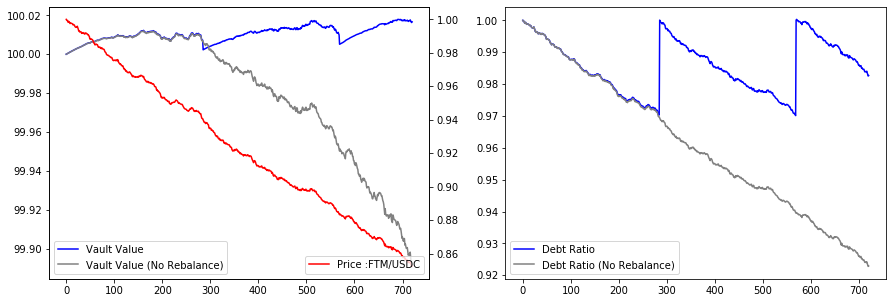

In [262]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value (No Rebalance)' )

ax.legend(loc = 'lower left')
ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price :' + secondaryToken + "/" + vaultToken)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend(loc = 'lower right')

ax = fig.add_subplot(1, 2, 2)

ax.plot(debtRatioLog, color = 'blue', label = 'Debt Ratio' )
ax.plot(debtRatioLog1, color = 'grey', label = 'Debt Ratio (No Rebalance)' )
ax.legend(loc = 'lower left')

plt.show()


Above graph shows how Vault with Rebalancing performs vs Vault with no rebalancing when price drops significantly 

In [263]:
# Simulate Price of Secondary PUMPING !!!

pBuy = .4 #high pBuy = more users buying vault Token and selling secondary token
lambdaTrades = 10 # input for poisson distribution to determine number of trades that occur in given time step
expScale = 100 # input for exponential distribution to determine size of trade 

allTrades = genSimulatedTrades()

vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates)
vol1, vol2, lp, vaultInitial = setInitialValues()
vaultLog1, priceLog1, debtRatioLog1, collatRatioLog1 = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                            secondaryToken, vol1, vol2, adjRates, rebalance = False)

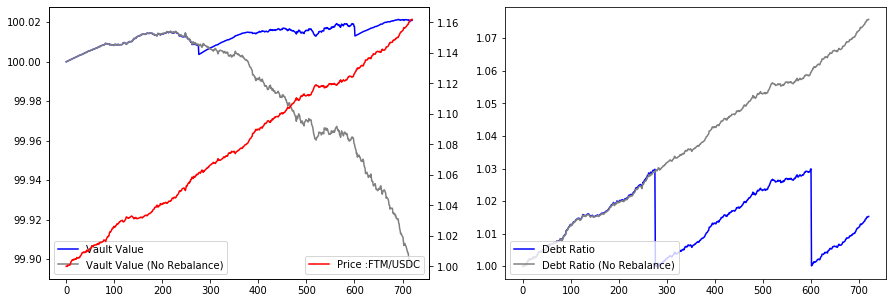

In [264]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(vaultLog, color = 'blue', label = 'Vault Value' )
ax.plot(vaultLog1, color = 'grey', label = 'Vault Value (No Rebalance)' )

ax.legend(loc = 'lower left')
ax2 = ax.twinx()
ax2.plot(priceLog, color = 'red', label = 'Price :' + secondaryToken + "/" + vaultToken)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
ax2.legend(loc = 'lower right')

ax = fig.add_subplot(1, 2, 2)

ax.plot(debtRatioLog, color = 'blue', label = 'Debt Ratio' )
ax.plot(debtRatioLog1, color = 'grey', label = 'Debt Ratio (No Rebalance)' )
ax.legend(loc = 'lower left')

plt.show()


In [235]:
#extereme price movements over 24h example 

nSteps = int(stepsPerYear / 365)
pLow = .2; pHigh = 1 - pLow
nSims = 100
expScale = 300
pBuy = pLow
pIncr = (pHigh - pLow) / nSims

apyLog = []
priceRangeLog = []
priceChangeLog = []
drawdownLog = []

for j in range(nSims) :     
    allTrades = genSimulatedTrades()

    vol1, vol2, lp, vaultInitial = setInitialValues()
    vaultLog, priceLog, debtRatioLog, collatRatioLog = simulate(allTrades, vaultInitial, lp, vaultToken, 
                                                                secondaryToken, vol1, vol2, adjRates)    
    apy, drawdown = simStats(vaultTVL, vaultLog)
    apyLog.append(apy)
    drawdownLog.append(drawdown)

    priceRangeLog.append(max(priceLog) / min(priceLog) - 1)
    priceChangeLog.append(priceLog[-1] / priceLog[0] - 1)
    pBuy += pIncr
    


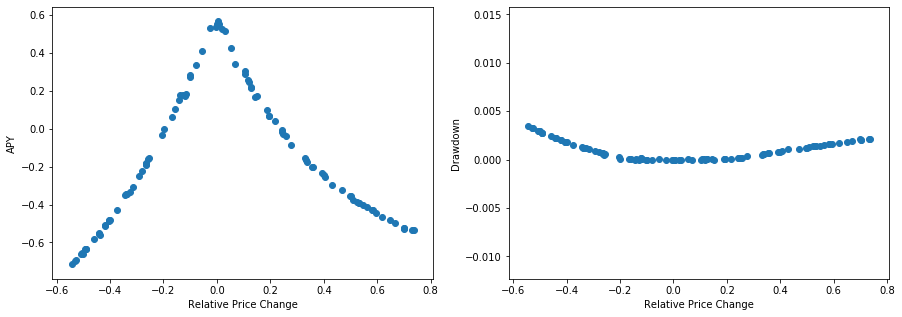

In [236]:
#plt.subplot()
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.set_ylabel('APY')
ax.set_xlabel('Relative Price Change')
plt.scatter(priceChangeLog, apyLog)
#ax.scatter(priceChangeLog, drawdownLog)
#ax2.plot(debtRatioLog, color = 'orange', label = 'Debt Ratio')
#ax2.legend()

ax = fig.add_subplot(1, 2, 2)
plt.scatter(priceChangeLog, drawdownLog)
ax.set_ylabel('Drawdown')
ax.set_xlabel('Relative Price Change')

plt.show()



APY vs Relative Price Change over period 

Drawdown vs Relative Price Change over period 